**Task-1**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from PIL import Image
import os


In [5]:
train_dir='/content/drive/MyDrive/FruitinAmazon/train'
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [6]:
from PIL import Image, UnidentifiedImageError

corrupted_images = [] # List to store corrupted images path

# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it’s a valid directory
    images = os.listdir(class_path)
    for img_name in images:
      img_path = os.path.join(class_path, img_name)
      try:
        with Image.open(img_path) as img:
          img.verify() # Verify image integrity
      except (IOError, UnidentifiedImageError):
        corrupted_images.append(img_path)
# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
  for img in corrupted_images:
    print(img)
else:
  print("\nNo corrupted images found.")


No corrupted images found.


In [7]:
import random
selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names

for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images: # Ensure the class folder is not empty
      selected_img = os.path.join(class_path, random.choice(images))
      selected_images.append(selected_img)
      selected_labels.append(class_name)

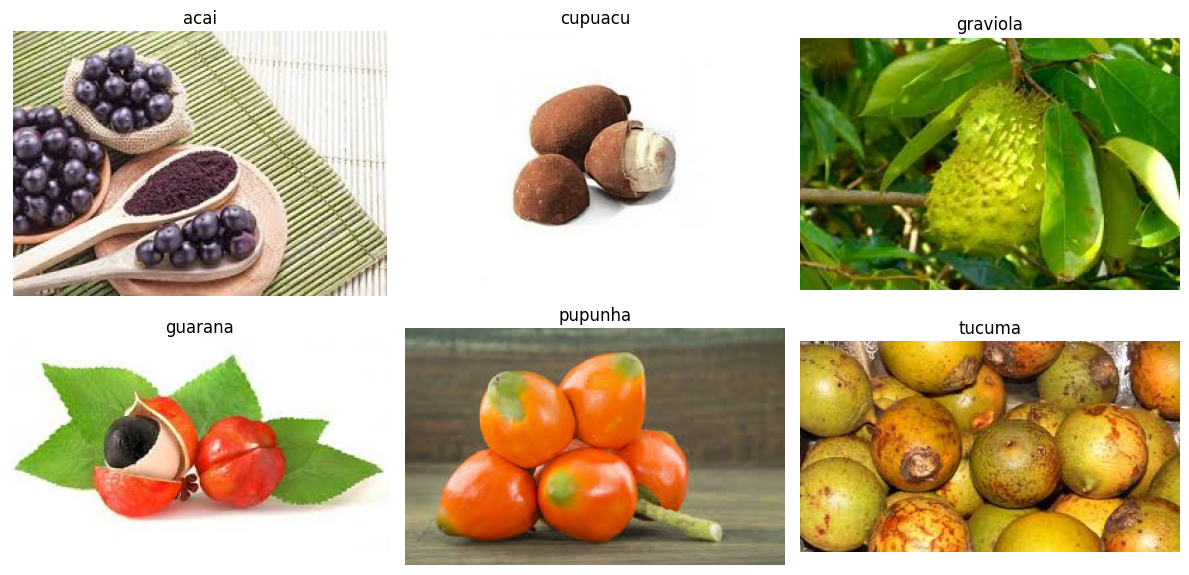

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2 # Determine columns
rows = 2 # Fixed rows for layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
  if i < num_classes:
    img = mpimg.imread(selected_images[i])
    ax.imshow(img)
    ax.set_title(selected_labels[i])
    ax.axis("off")
  else:
    ax.axis("off") # Hide empty subplots

plt.tight_layout()
plt.show()

In [9]:
import keras

image_size = (28, 28)
batch_size = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="both",
  seed=1337,
  image_size=image_size,
  batch_size=batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


In [10]:
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)

Images shape: (32, 28, 28, 3)
Labels shape: (32,)


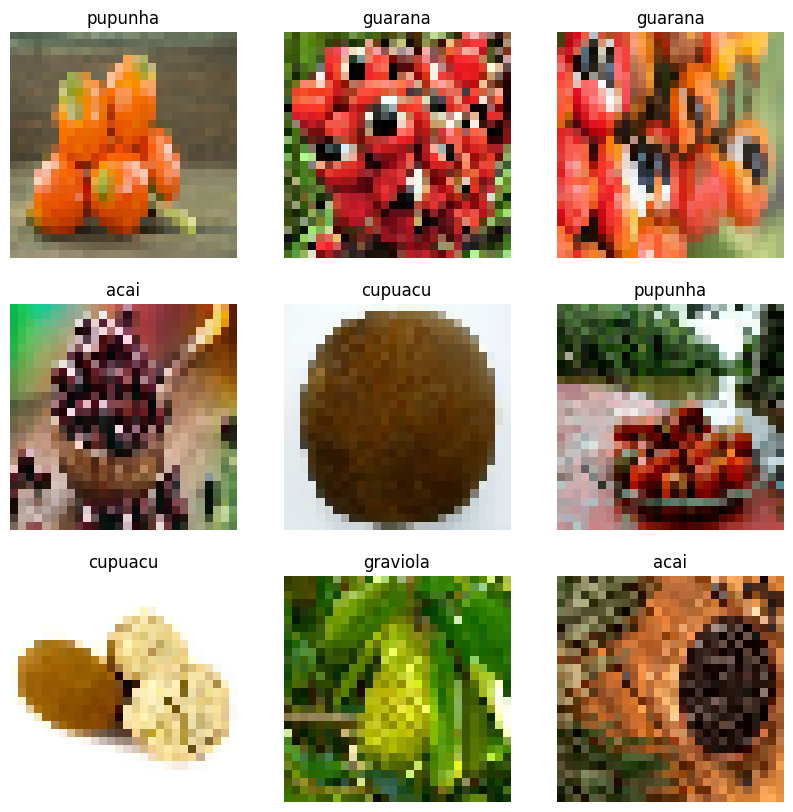

In [11]:
import numpy as np

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  # Takes one batch of images from the dataset (train_ds):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

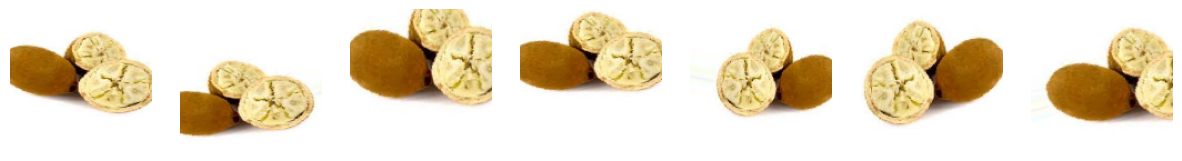

In [13]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  rotation_range=30, # Rotate images by up to 30 degrees
  width_shift_range=0.2, # Shift width by 20%
  height_shift_range=0.2, # Shift height by 20%
  shear_range=0.2, # Shear transformation
  zoom_range=0.2, # Zoom in/out by 20%
  horizontal_flip=True, # Flip images horizontally
  fill_mode='nearest' # Fill in missing pixels
)

# Load an example image
from tensorflow.keras.preprocessing import image

image_direct ='/content/drive/MyDrive/FruitinAmazon/train/cupuacu/images (11).jpeg'

img = image.load_img(image_direct, target_size=(128, 128))
x = image.img_to_array(img) # Convert to NumPy array
x = np.expand_dims(x, axis=0)

# Generate augmented images
aug_iter = datagen.flow(x, batch_size=1)

# Visualize 7 augmented images
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
  batch = next(aug_iter)
  ax[i].imshow(batch[0].astype('uint8'))
  ax[i].axis('off')
plt.show()

In [14]:
from tensorflow.keras import layers as layers

data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  ]
def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [15]:
model = keras.Sequential([
  layers.Input(shape=(128, 128, 3)),
  *data_augmentation_layers, # Include augmentation before the model layers
  layers.Conv2D(32, (3,3), activation="relu"),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(10, activation="softmax")
])

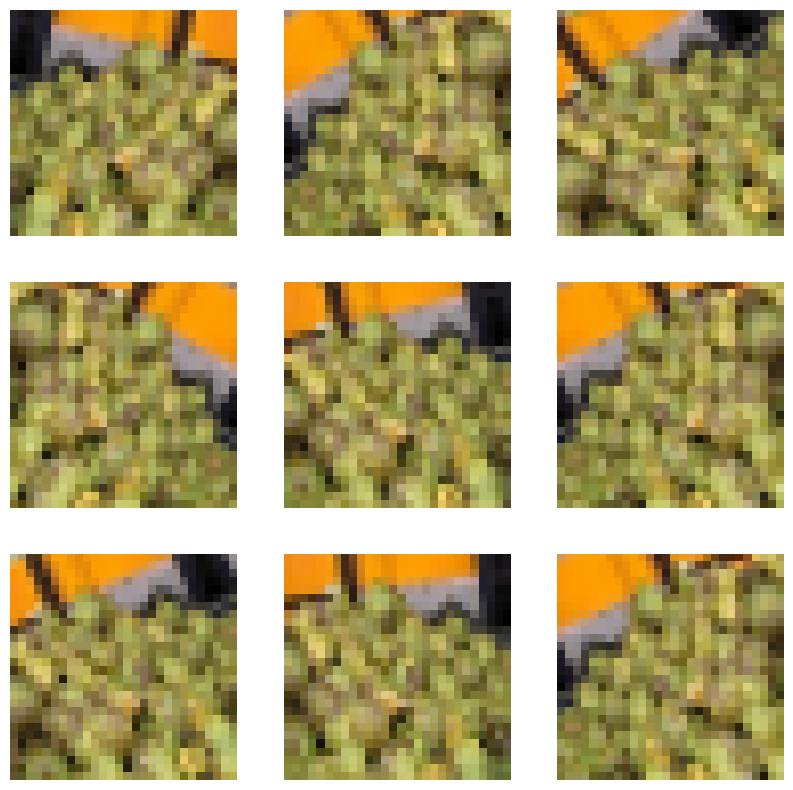

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(augmented_images[0]).astype("uint8"))
    plt.axis("off")

In [17]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [18]:
# Converting the Dataset to GreyScale
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(28, 28),
    color_mode='grayscale',  # Convert to grayscale
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(28, 28),
    color_mode='grayscale',  # Convert to grayscale
    batch_size=32
)

Found 90 files belonging to 6 classes.
Found 90 files belonging to 6 classes.


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - accuracy: 0.0885 - loss: 19.2612 - val_accuracy: 0.2000 - val_loss: 14.8211
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - accuracy: 0.2312 - loss: 14.6726 - val_accuracy: 0.2222 - val_loss: 11.0607
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - accuracy: 0.2505 - loss: 8.9215 - val_accuracy: 0.2889 - val_loss: 3.3615
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step - accuracy: 0.2244 - loss: 3.7130 - val_accuracy: 0.3111 - val_loss: 3.8454
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step - accuracy: 0.3157 - loss: 3.6641 - val_accuracy: 0.4222 - val_loss: 2.1368
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4064 - loss: 2.2122
Test accuracy: 0.4222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted class names:
guarana
acai
pupunha
guarana
pupunha


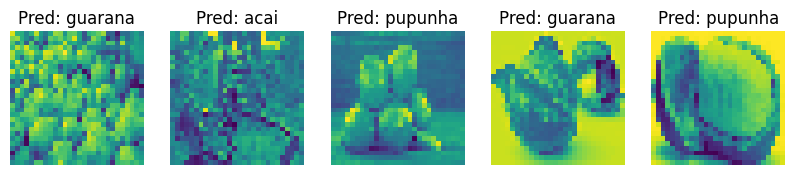

In [19]:
# Define a simple CNN model
model = keras.Sequential([
  layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation="relu"),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(10, activation="softmax") # 10 classes for MNIST digits
])

# Compile the model
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

# Train the model
model.fit(train_ds, epochs=5, batch_size=32, validation_data=val_ds)
# Evaluate the model
test_loss, test_acc = model.evaluate(train_ds)
print(f"Test accuracy: {test_acc:.4f}")
# Make predictions
# predictions = model.predict(x_test[:5])
# predicted_labels = np.argmax(predictions, axis=1)
# print("Predicted labels:", predicted_labels)

# Get the class names from the dataset
class_names = val_ds.class_names

# Make predictions and print class names
for images, labels in val_ds.take(1):  # Take one batch from the validation dataset
    predictions = model.predict(images[:5])  # Predict for the first 5 images
    predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the highest probability for each image

    # Print predicted class names
    print("Predicted class names:")
    for label in predicted_labels:
        print(class_names[label])  # Print the class name instead of the label number

    # Optionally, show the images with their predictions
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()


In [20]:
data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
]

In [21]:
def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [22]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    # Data augmentation applied using Lambda layer
    layers.Lambda(data_augmentation, input_shape=(224, 224, 3)),
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Fourth Convolutional Block
    layers.Conv2D(256, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Flatten the output of the last Conv2D layer
    layers.Flatten(),
    # First Fully Connected Layer
    layers.Dense(512, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Second Fully Connected Layer
    layers.Dense(256, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Third Fully Connected Layer
    layers.Dense(128, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Fourth Fully Connected Layer
    layers.Dense(64, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Output Layer with 10 neurons (for classification task with 10 classes)
    layers.Dense(10, activation='softmax')
])

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             

 Total params: 26,257,930 (100.17 MB)

 Trainable params: 26,255,050 (100.16 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [23]:
from tensorflow.keras.applications import VGG16
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
# Freeze the layers of the base model
for layer in base_model.layers:
  layer.trainable = False

In [25]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation='relu')(x) # Fully connected layer with 1024 neurons
x = Dense(10, activation='softmax')(x) # Output layer for 10 classes (with softmax for multi-classclassification)

In [26]:
from tensorflow.keras.models import Model
# Create the final model
model = Model(inputs=base_model.input, outputs=x)

In [27]:
from tensorflow.keras.optimizers import Adam
# Compile the model

train_ds, val_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="both",
  seed=1337,
  image_size=(224,224),
  batch_size=32,
)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, epochs=5, validation_data=val_ds)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 79s 27s/step - accuracy: 0.1341 - loss: 8.4568 - val_accuracy: 0.2222 - val_loss: 8.9389
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 76s 25s/step - accuracy: 0.6606 - loss: 2.9449 - val_accuracy: 0.2778 - val_loss: 9.5060
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 24s/step - accuracy: 0.8368 - loss: 1.4798 - val_accuracy: 0.3889 - val_loss: 5.0005
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 64s 21s/step - accuracy: 0.9627 - loss: 0.1379 - val_accuracy: 0.5000 - val_loss: 3.5907
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 71s 25s/step - accuracy: 1.0000 - loss: 0.0159 - val_accuracy: 0.5556 - val_loss: 3.7721


In [28]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,321,376 (62.26 MB)

 Trainable params: 535,562 (2.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,071,126 (4.09 MB)

**Task-2**

**Load Pre-trained VGG16**

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False



Add Custom Layers

In [30]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)  # Output layer for 6 classes

model = Model(inputs=base_model.input, outputs=x)



Compile the Model

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train the Model


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/FruitinAmazon/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/FruitinAmazon/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator)


Found 90 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 99s 39s/step - accuracy: 0.1396 - loss: 1.9380 - val_accuracy: 0.2000 - val_loss: 1.8224
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 106s 41s/step - accuracy: 0.1715 - loss: 1.9164 - val_accuracy: 0.2333 - val_loss: 1.7978
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 110s 40s/step - accuracy: 0.2227 - loss: 1.7982 - val_accuracy: 0.2000 - val_loss: 1.7790
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 31s/step - accuracy: 0.1514 - loss: 1.9429 - val_accuracy: 0.2000 - val_loss: 1.7642
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 33s/step - accuracy: 0.1899 - loss: 1.9374 - val_accuracy: 0.2000 - val_loss: 1.7525
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 105s 43s/step - accuracy: 0.2178 - loss: 1.8484 - val_accuracy: 0.2667 - val_loss: 1.7429
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 105s 43s/step - accuracy: 0.1988 - loss: 1.9137 - val_accuracy: 0.3000 - val_loss: 1.7331
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 105s 40s/step - accuracy: 0.2339 - loss: 1.8636 - val_accuracy: 0.3000 - val_loss: 1.

In [ ]:
model.save("/content/drive/MyDrive/AI and ML Workshop/Week-5/FruitinAmazon/vgg16_fruit_classifier.h5")


In [35]:
# Show model summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,511,892 (59.17 MB)

 Trainable params: 265,734 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 531,470 (2.03 MB)

Classification report

In [36]:
from sklearn.metrics import classification_report
import numpy as np

val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step
              precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.00      0.00      0.00         5
    graviola       0.27      0.60      0.38         5
     guarana       0.29      0.40      0.33         5
     pupunha       0.33      0.20      0.25         5
      tucuma       0.00      0.00      0.00         5

    accuracy                           0.20        30
   macro avg       0.15      0.20      0.16        30
weighted avg       0.15      0.20      0.16        30



Compared to the previous model trained from scratch, the VGG16-based transfer learning model demonstrated significantly better validation accuracy. However, its test performance remains limited, indicating potential issues with generalization.